### How to do TI analysis

Today we are going to walk you through some analysis steps for TI.


The following steps we will walk through

- Loading data
- Standard quality control
- PCA embedding
- diffusion map pseudotime
- various plots
- id dynamically expresssed genes
- cell typing 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy as sp
import numpy as np
import warnings

sc.settings.set_figure_params(dpi=80)
warnings.filterwarnings('ignore')


In [3]:
adata = sc.read_h5ad("/Users/patrickcahan/Dropbox (Personal)/data/cscb/2022/d4/cscb_2022_d4_raw.h5ad")
adata.obs['sampleName'] = "mEB_day4"
adata

AnnData object with n_obs × n_vars = 5405 × 27998
    obs: 'sampleName', 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

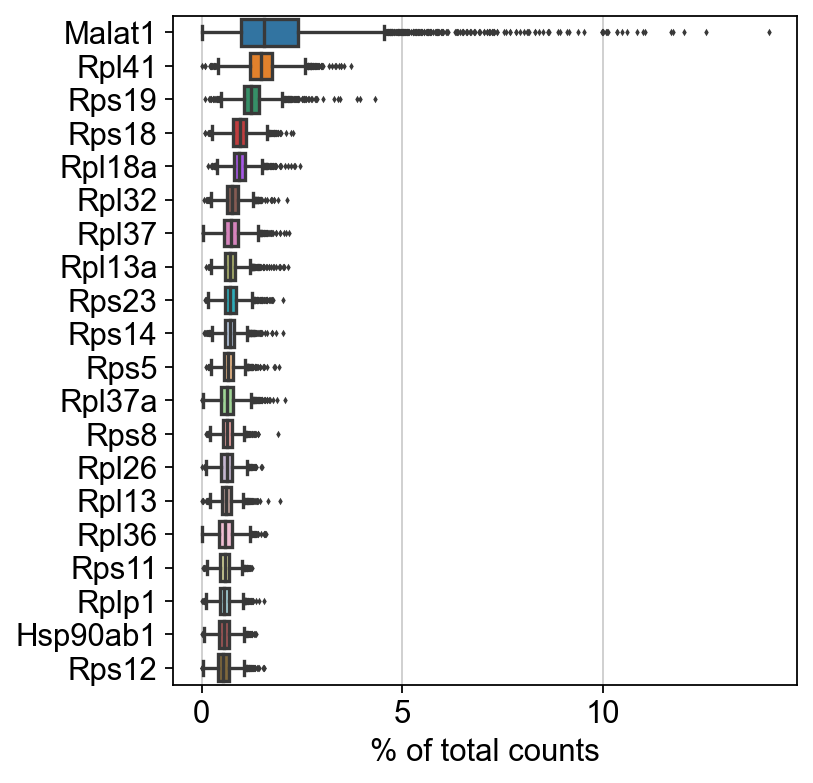

In [4]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [5]:
adata.var['mt']= adata.var_names.str.startswith(("mt-"))
adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl"))
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

... storing 'sampleName' as categorical


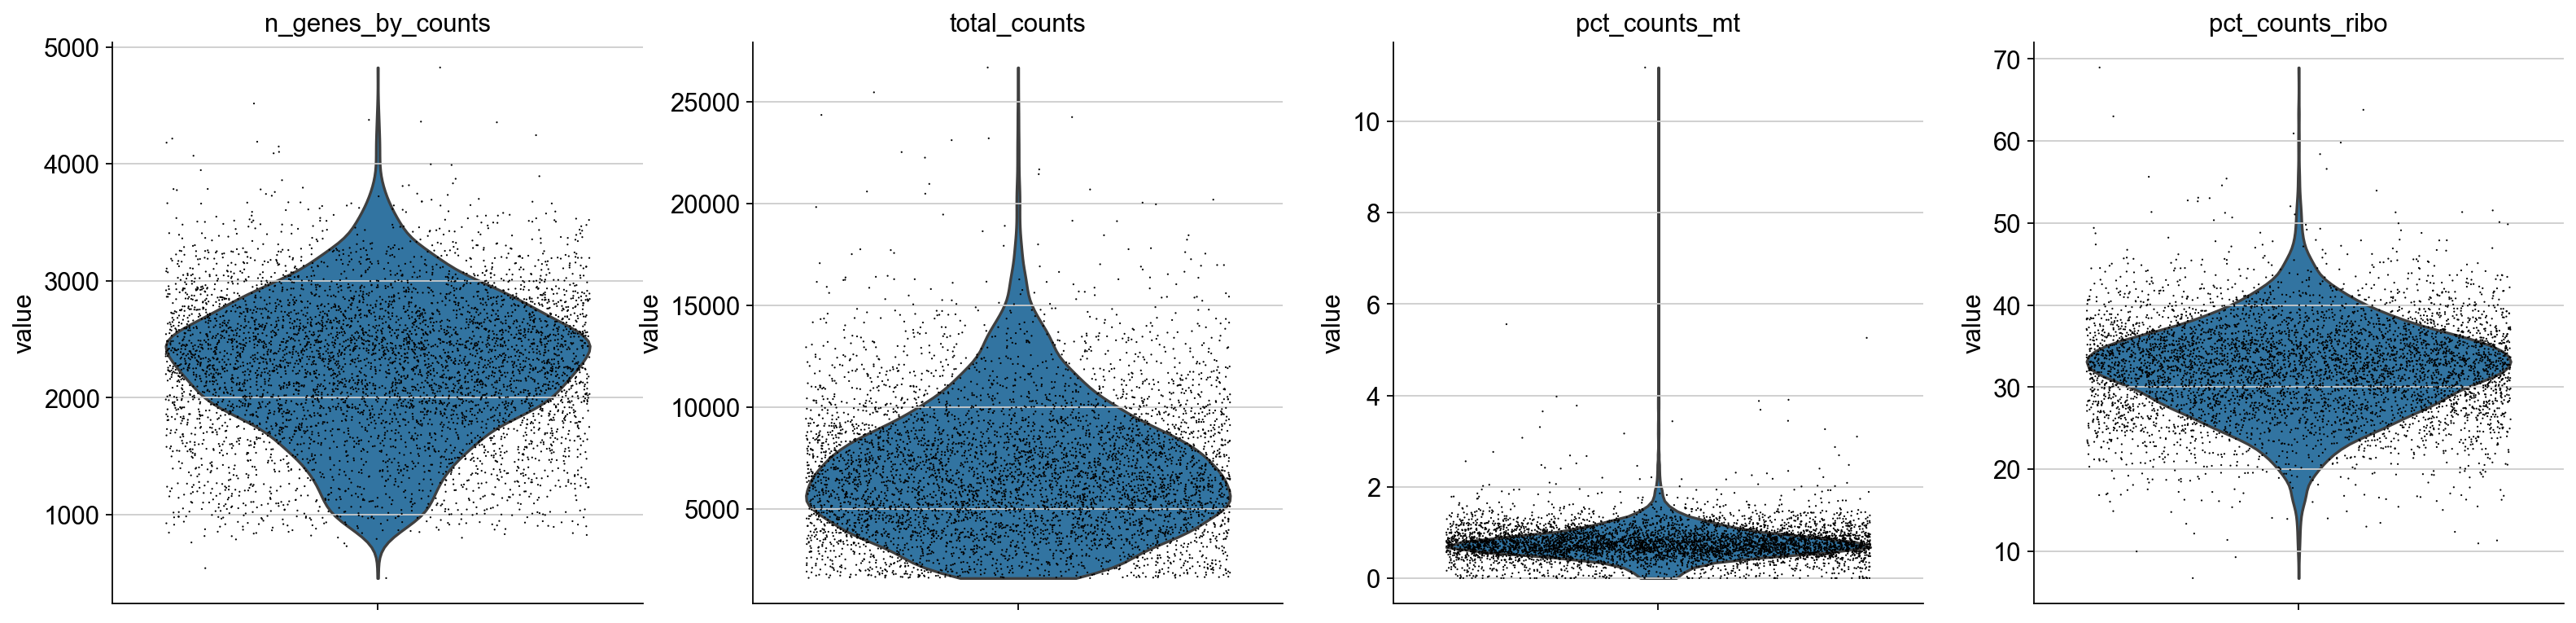

In [6]:
axs = sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],jitter=0.4, multi_panel=True)

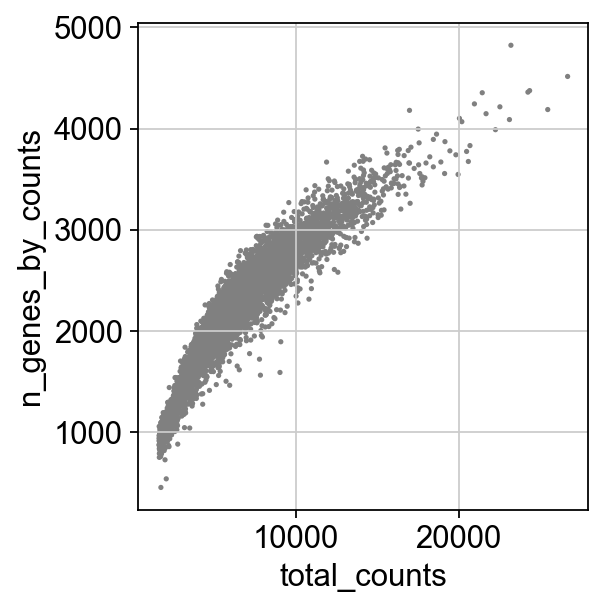

In [7]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [8]:
print("Number of cells: ",adata.n_obs)

# figure out the total counts == 95 percentile
thresh = np.percentile(adata.obs['total_counts'],95)
print("95th percentile: ",thresh)

adata = adata[adata.obs['total_counts'] < thresh, :]
print("Number of cells: ",adata.n_obs)


Number of cells:  5405
95th percentile:  12928.400000000001
Number of cells:  5134


In [9]:
mito_genes = adata.var_names.str.startswith('mt-')
ribo_genes = adata.var_names.str.startswith(("Rpl","Rps"))
malat_gene = adata.var_names.str.startswith("Malat1")

remove = np.add(mito_genes, ribo_genes)
remove = np.add(remove, malat_gene)
keep = np.invert(remove)

print(len(keep) - np.count_nonzero(keep))

adata = adata[:,keep].copy()
print("Number of genes: ",adata.n_vars)

127
Number of genes:  27871


In [10]:

adM1Norm = adata.copy()
sc.pp.filter_genes(adM1Norm, min_cells=5)
sc.pp.normalize_per_cell(adM1Norm, counts_per_cell_after=1e4)
sc.pp.log1p(adM1Norm)
sc.pp.highly_variable_genes(adM1Norm, min_mean=0.0125, max_mean=5, min_disp=0.25)

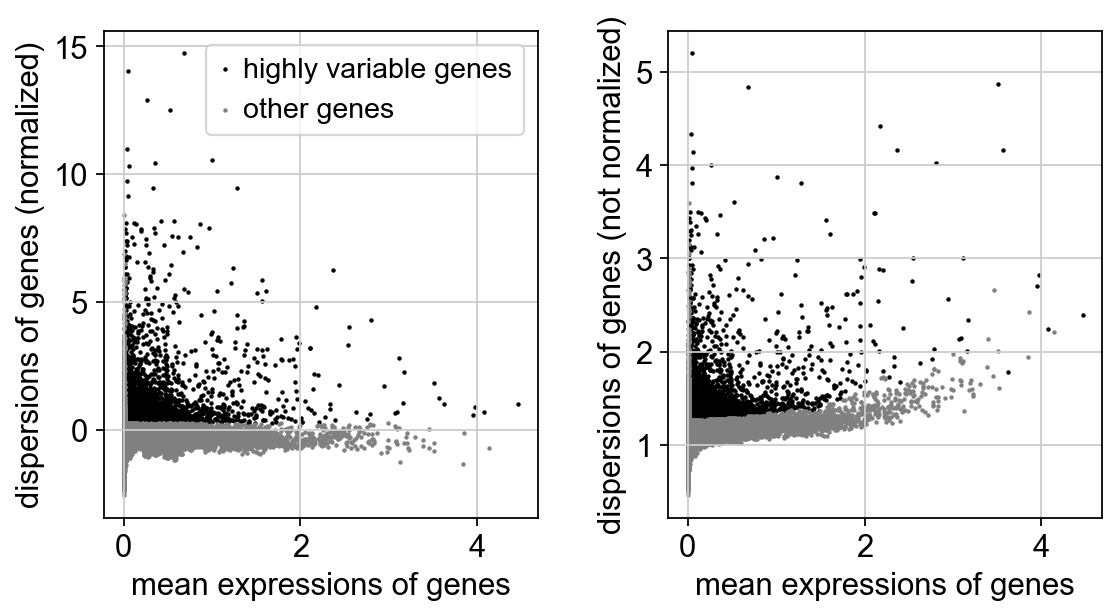

In [11]:
sc.pl.highly_variable_genes(adM1Norm)

In [12]:

adM1Norm.raw = adM1Norm
sc.pp.scale(adM1Norm, max_value=10)
sc.tl.pca(adM1Norm, n_comps=100)


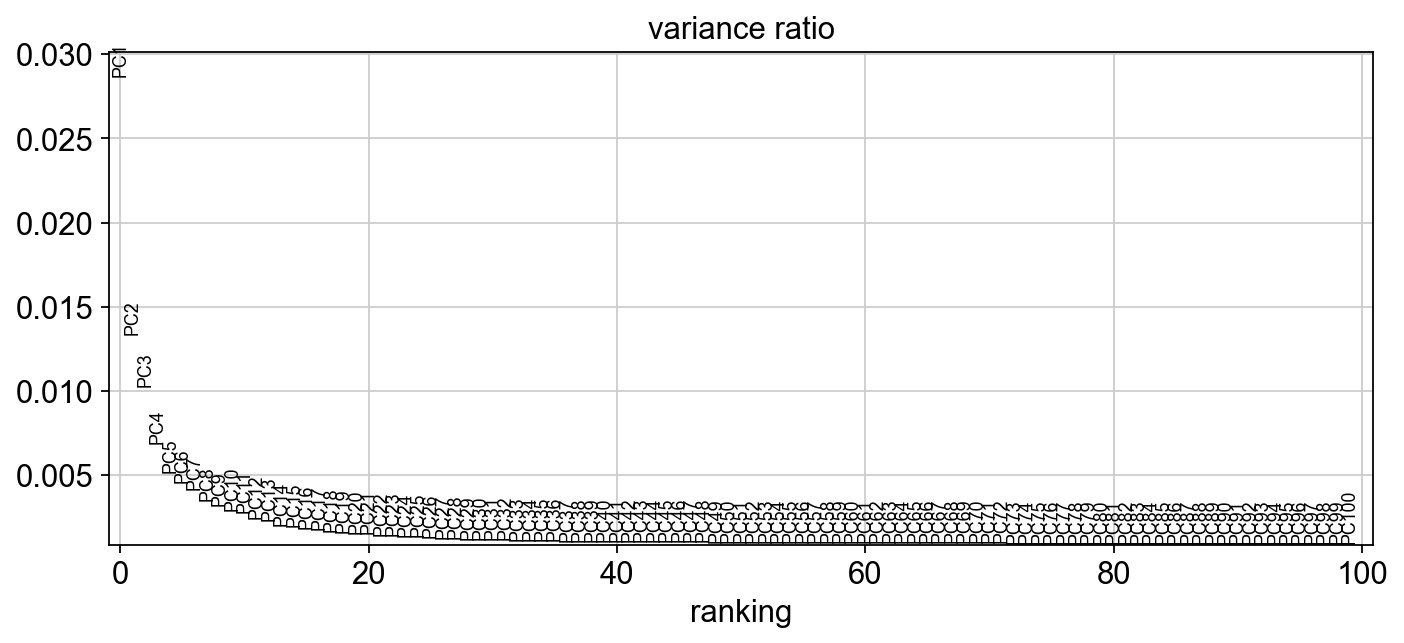

In [13]:

sc.set_figure_params(figsize="10, 4")
sc.pl.pca_variance_ratio(adM1Norm, 100)

In [14]:
npcs = 15
nknns = 15
sc.pp.neighbors(adM1Norm, n_neighbors=nknns, n_pcs=npcs)
sc.tl.leiden(adM1Norm,.25)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<AxesSubplot:title={'center':'leiden'}, xlabel='PC1', ylabel='PC3'>

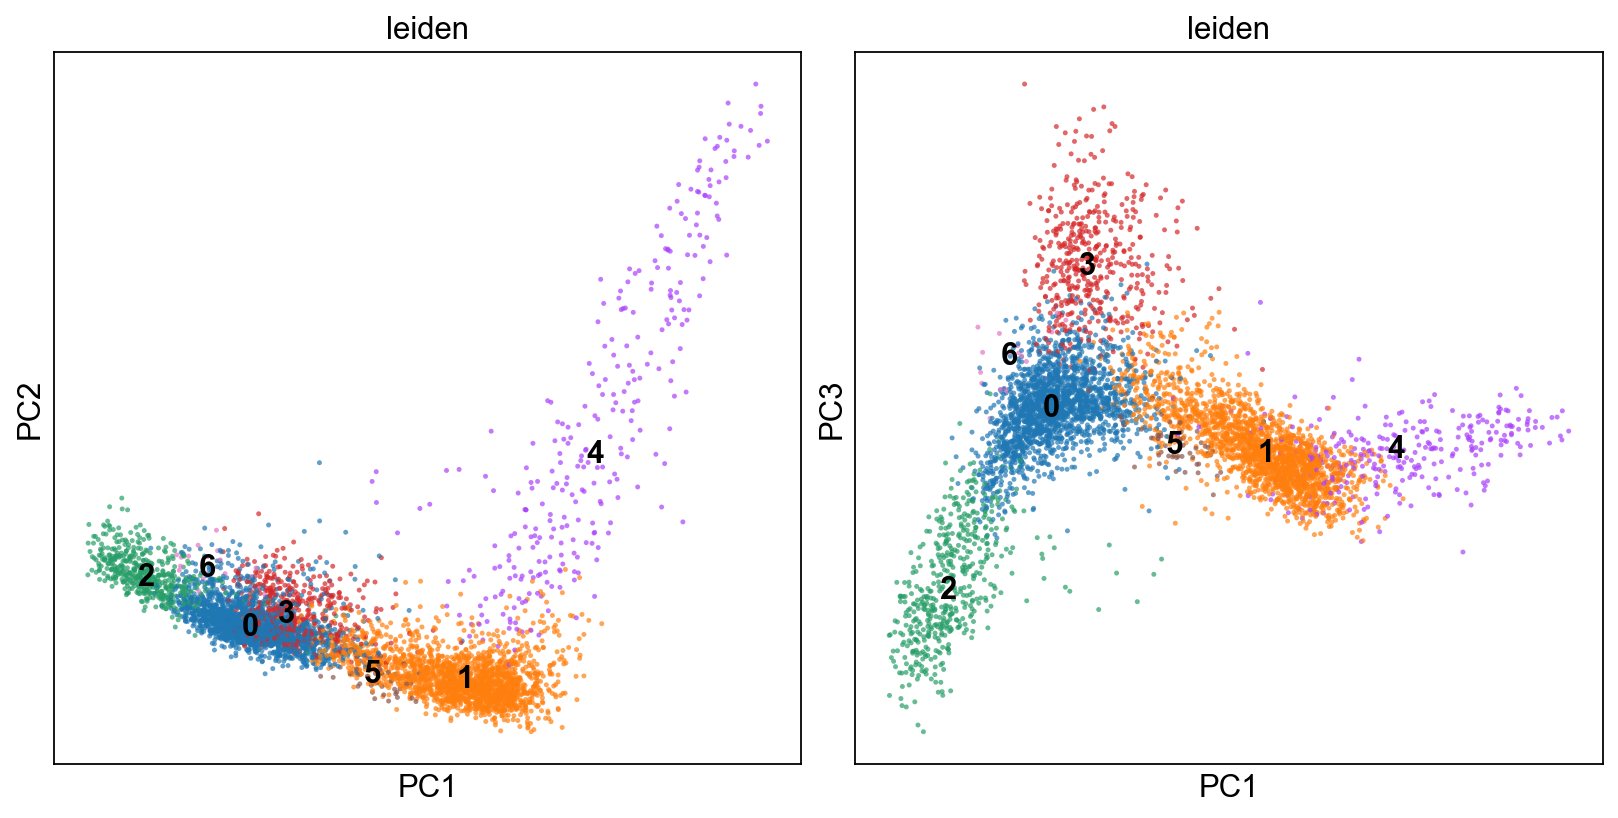

In [15]:
fig, axs = plt.subplots(1,2, figsize=(10,5), constrained_layout=True)
sc.pl.pca(adM1Norm, color=["leiden"], alpha=.7, s=20, components="1,2",legend_loc='on data', ax=axs[0], show=False)
sc.pl.pca(adM1Norm, color=["leiden"], alpha=.7, s=20, components="1,3",legend_loc='on data', ax=axs[1], show=False)

In [16]:
sc.tl.rank_genes_groups(adM1Norm, 'leiden')

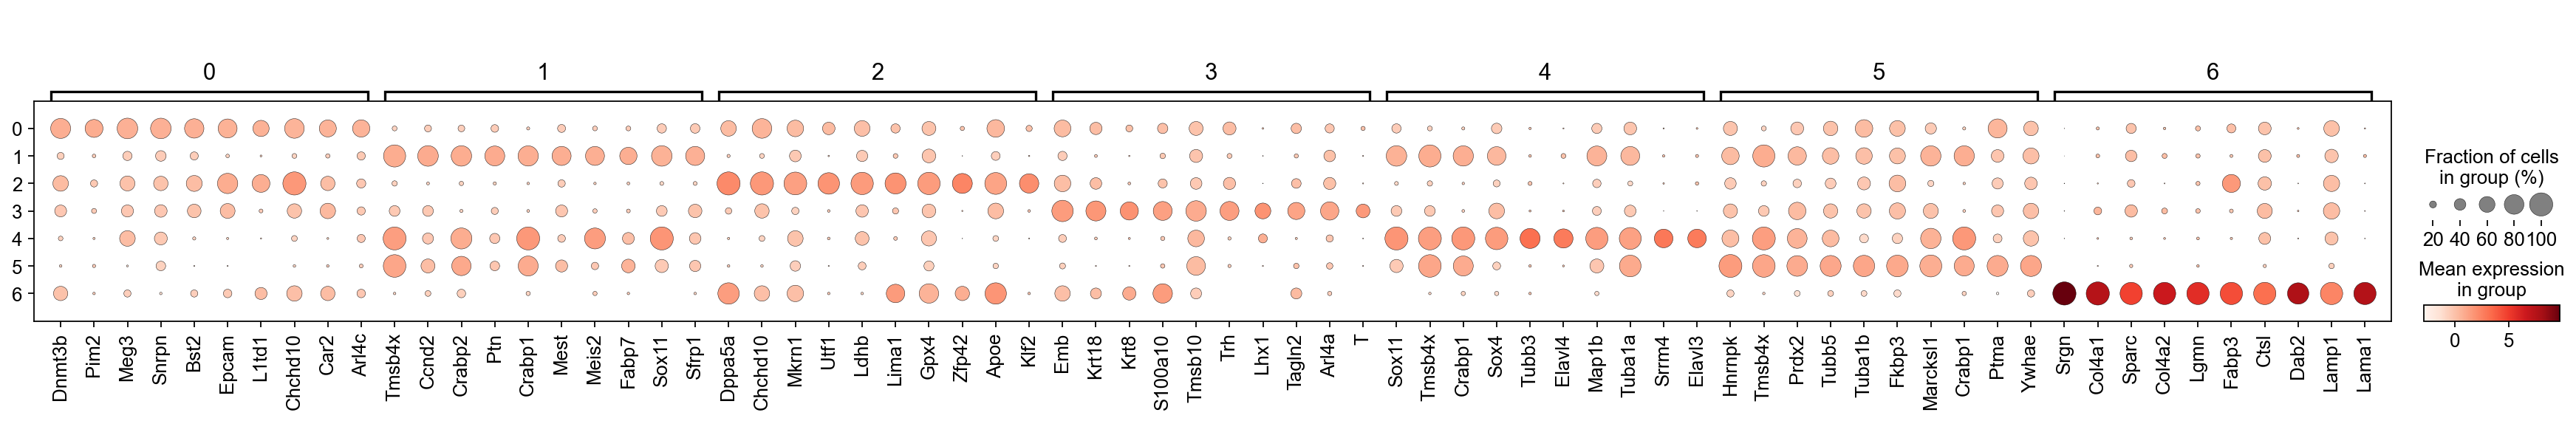

In [18]:
sc.pl.rank_genes_groups_dotplot(adM1Norm, n_genes=10, groupby='leiden', use_raw=False, dendrogram=False)

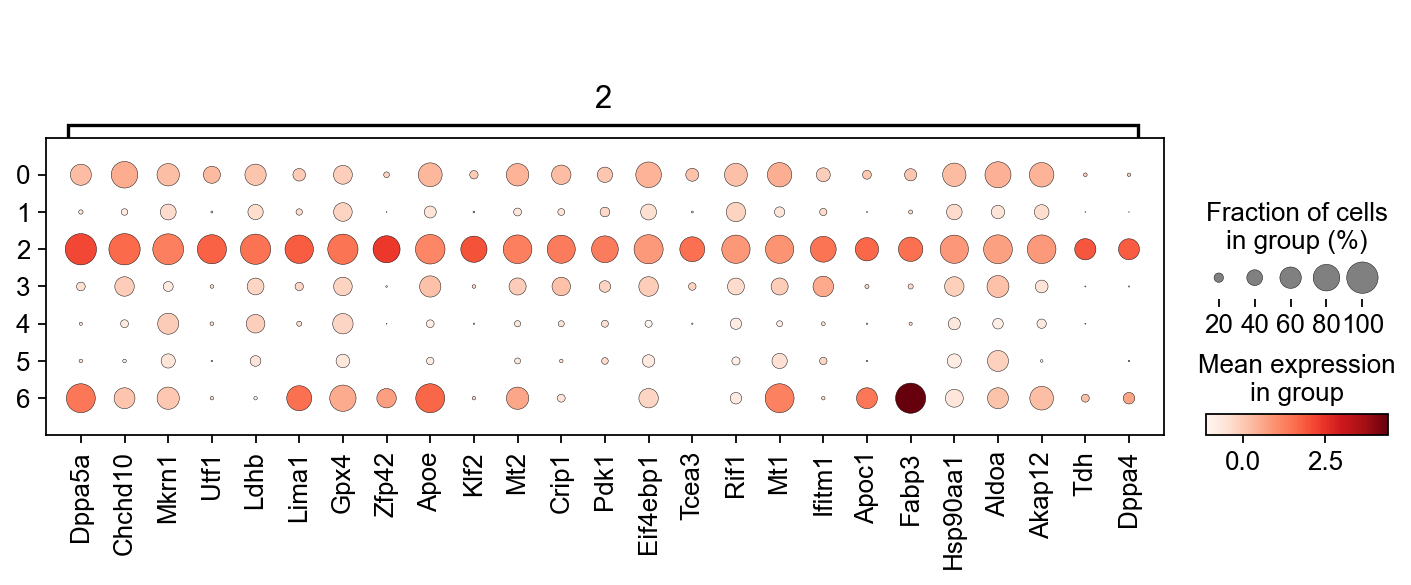

In [64]:
sc.pl.rank_genes_groups_dotplot(adM1Norm, n_genes=25, groupby='leiden', groups=["2"],use_raw=False, dendrogram=False)

In [65]:
adM1X = adM1Norm[adM1Norm.obs['leiden'] != "6"].copy()
adM1X = adM1X[adM1X.obs['leiden'] != "5"].copy()
adM1X

AnnData object with n_obs × n_vars = 5060 × 15567
    obs: 'sampleName', 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden'
    var: 'gene_ids', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

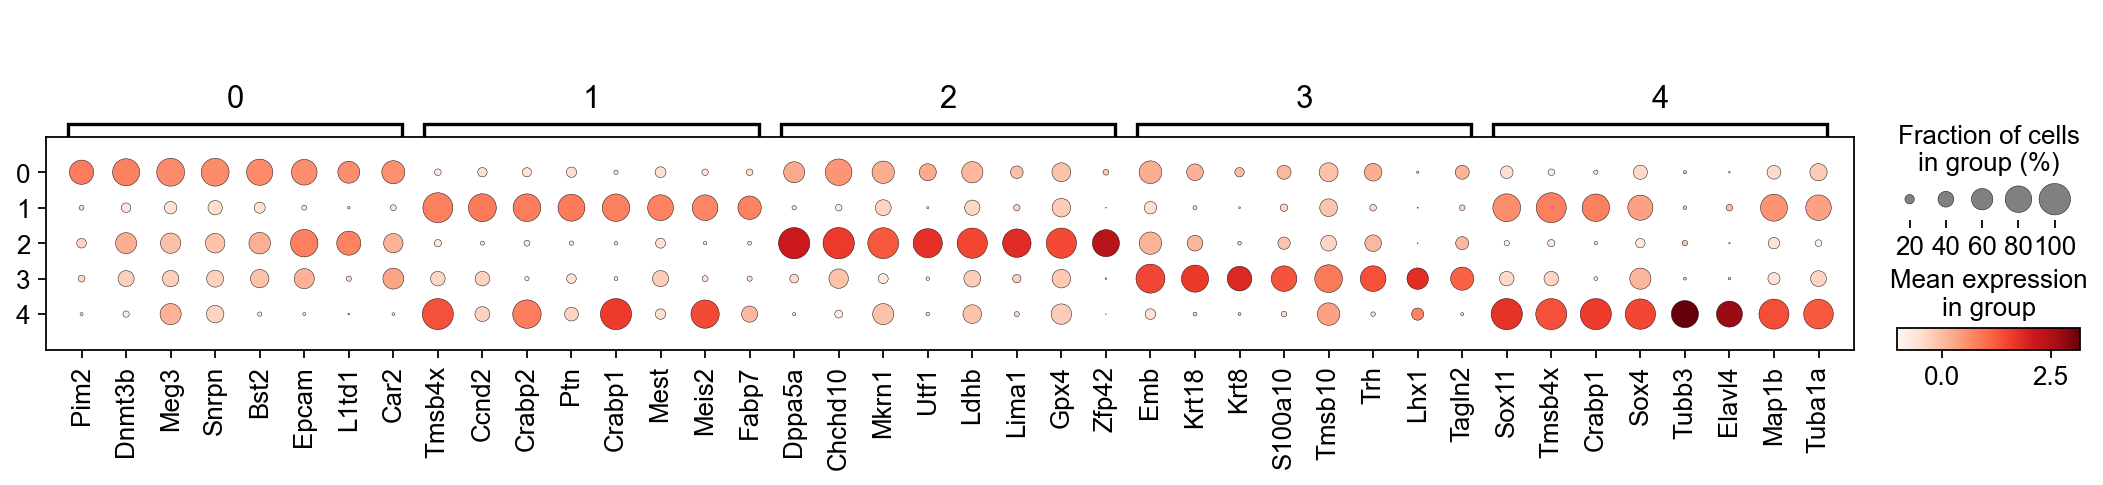

In [66]:
sc.tl.rank_genes_groups(adM1X, 'leiden')
sc.pl.rank_genes_groups_dotplot(adM1X, n_genes=8, groupby='leiden', use_raw=False, dendrogram=False)

Based on this, I think the following cluster annotation makes sense:

0. Primed
1. Ect
2. Naive
3. PrimStr
4. NeurEct

Let's rename the clusters

In [67]:
new_sc_names = ["Primed","Ect", "Naive", "PrimStr", "NeurEct"]
adM1X.rename_categories('leiden', new_sc_names)

In [69]:
sc.tl.diffmap(adM1X)

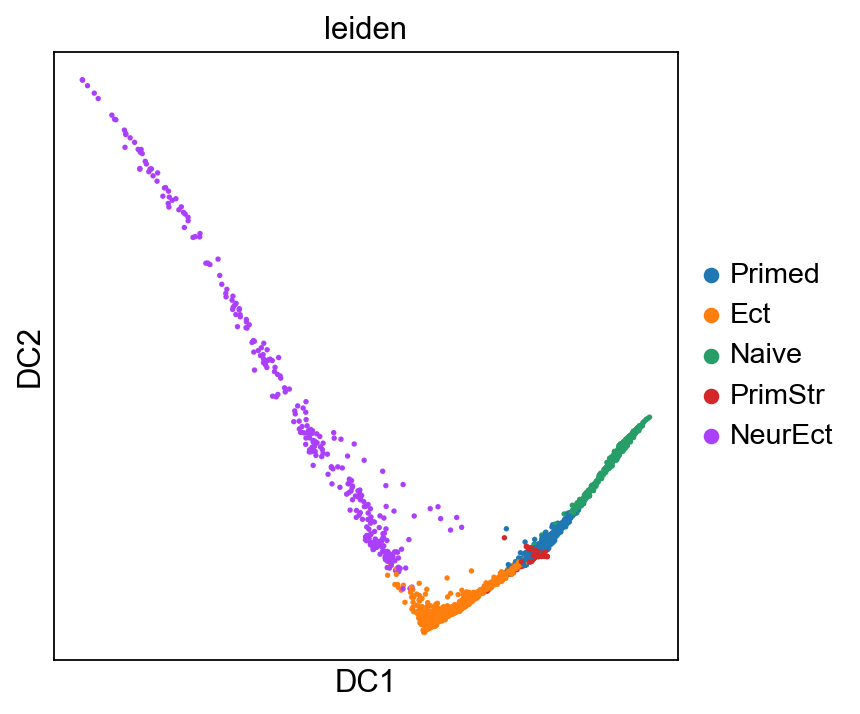

In [70]:
sc.pl.diffmap(adM1X, color="leiden")

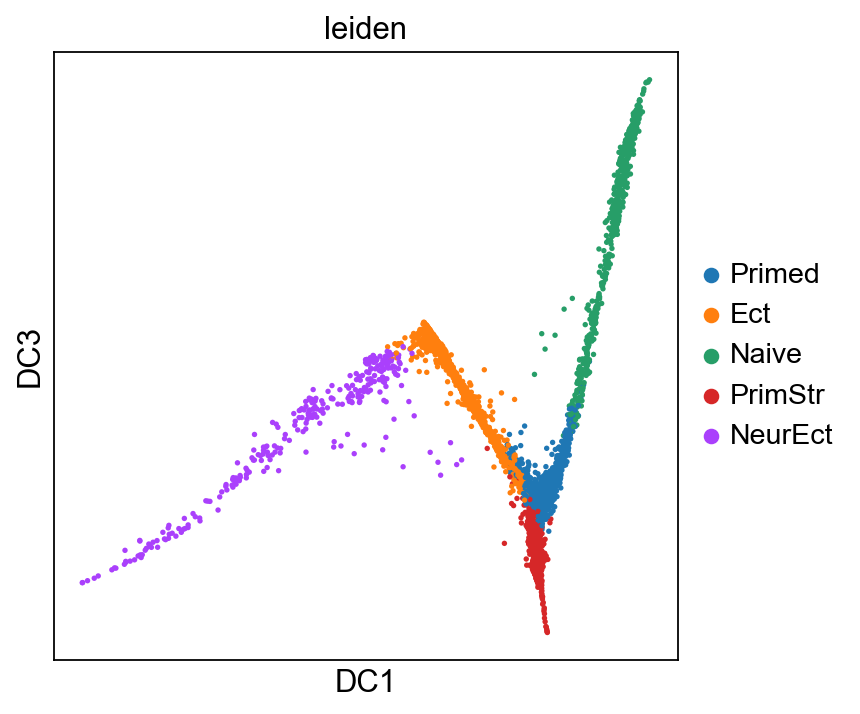

In [71]:
sc.pl.diffmap(adM1X, color="leiden", components=["1,3"])

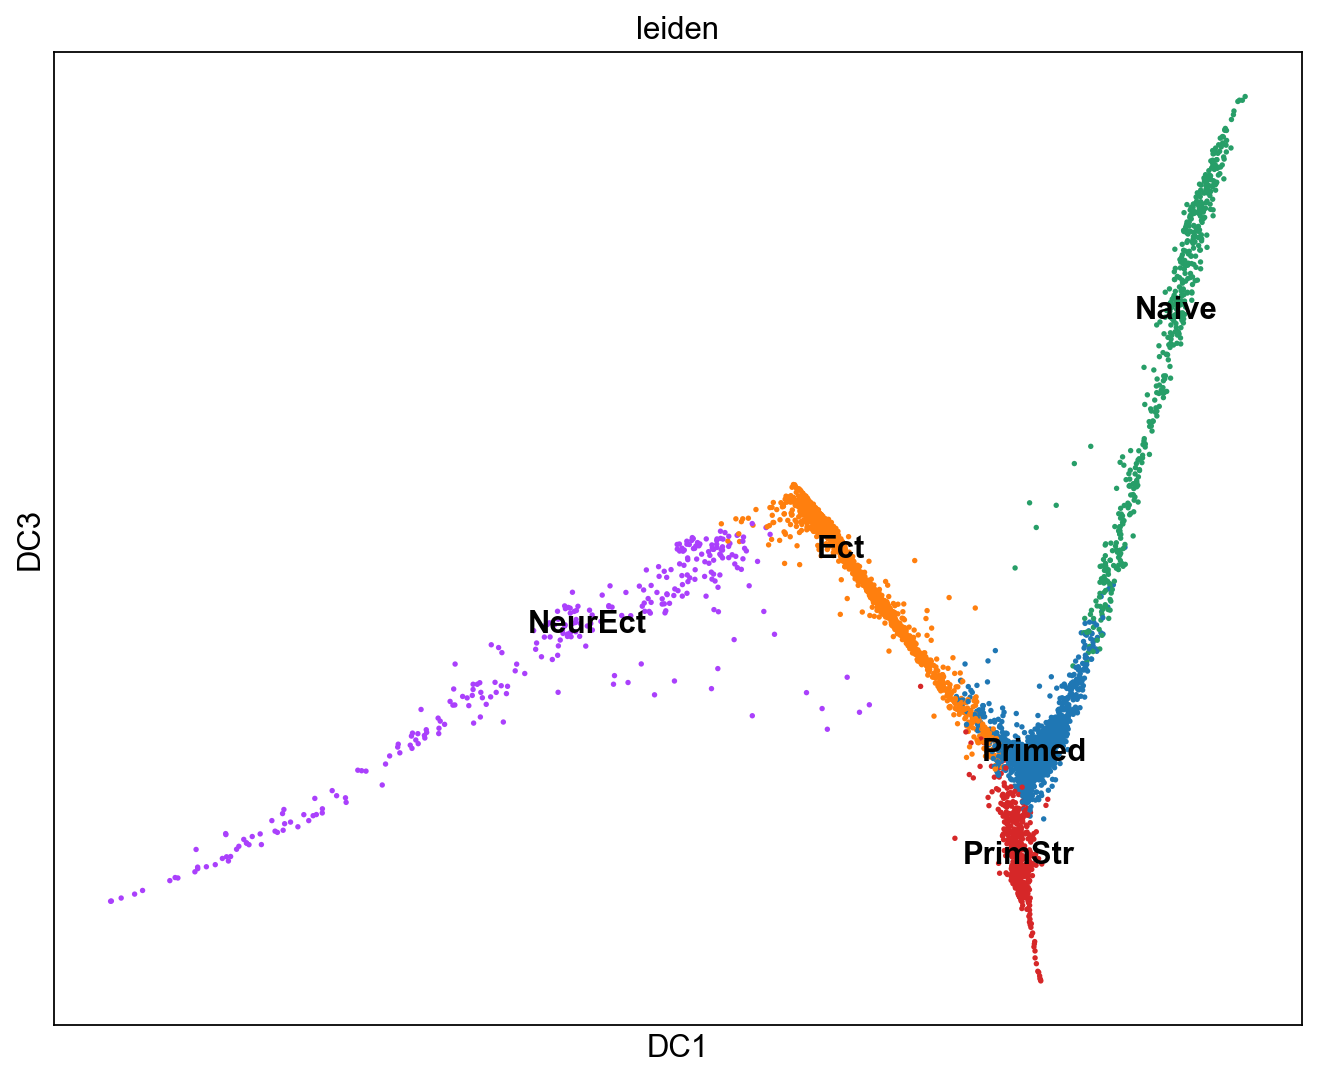

In [24]:
sc.set_figure_params(figsize="10, 8")
sc.pl.diffmap(adM1X, color="leiden", components=("1,3"), legend_loc='on data')

In [74]:
adM1X.uns['iroot'] = np.flatnonzero(adM1X.obs['leiden']  == 'Naive')[0]

In [78]:
adM1X


AnnData object with n_obs × n_vars = 5060 × 15567
    obs: 'sampleName', 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices'
    var: 'gene_ids', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'leiden_colors', 'rank_genes_groups', 'diffmap_evals', 'iroot', 'dpt_changepoints', 'dpt_grouptips'
    obsm: 'X_pca', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [75]:
sc.tl.dpt(adM1X, n_branchings=1)

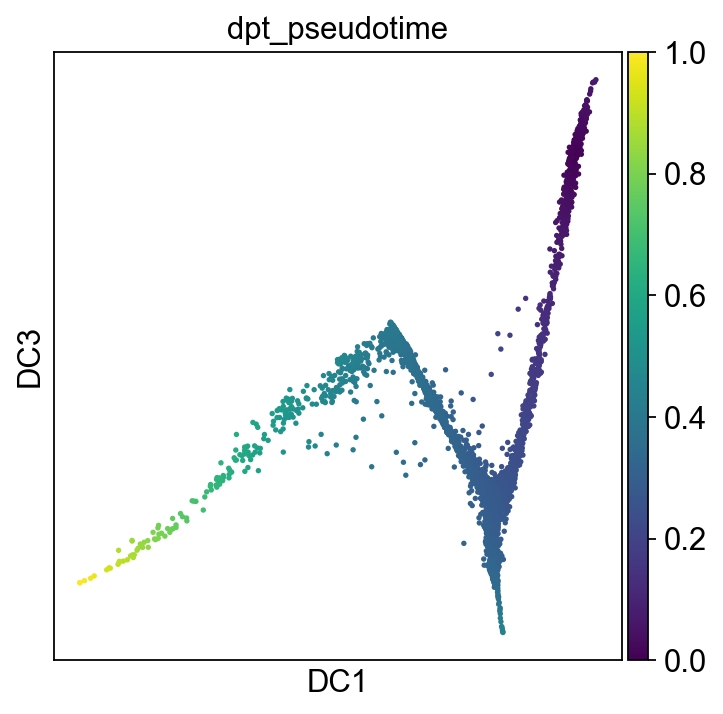

In [76]:
sc.pl.diffmap(adM1X, color="dpt_pseudotime", components=("1,3"), legend_loc='on data')

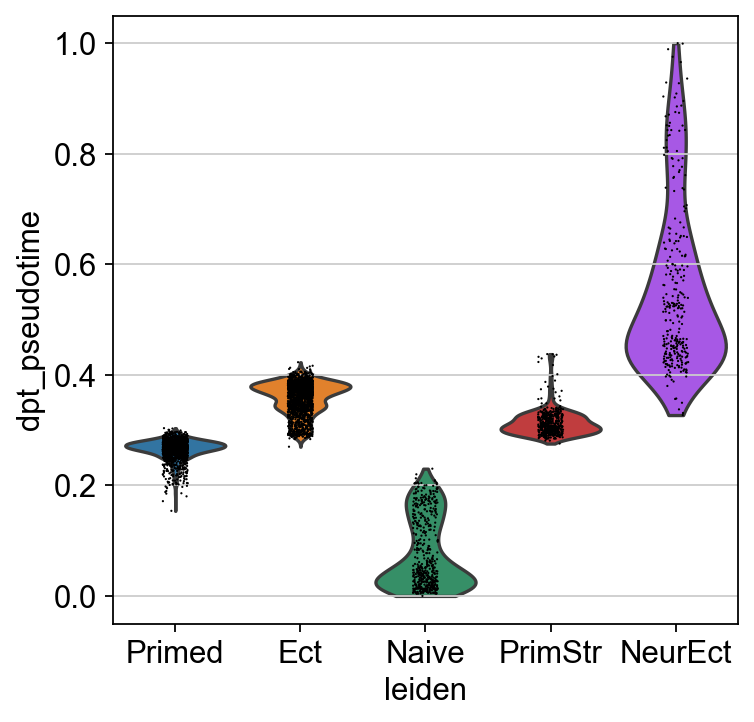

In [79]:
sc.pl.violin(adM1X, "dpt_pseudotime", groupby="leiden")

In [80]:
adM1X.obs['leiden'].cat.categories

Index(['Primed', 'Ect', 'Naive', 'PrimStr', 'NeurEct'], dtype='object')

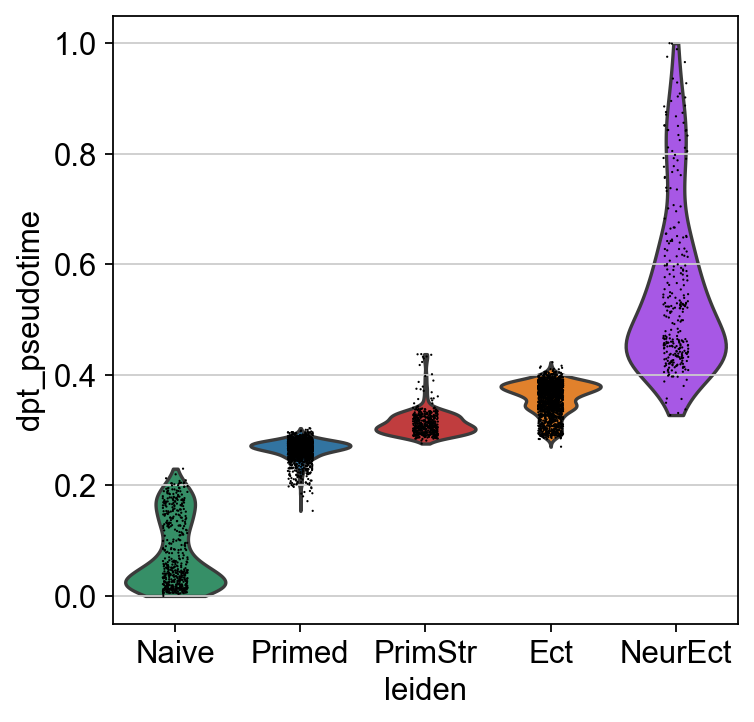

In [81]:
vorder = adM1X.obs['leiden'].cat.categories[[2,0,3,1,4]]
sc.pl.violin(adM1X, "dpt_pseudotime", groupby="leiden", order=vorder)


<AxesSubplot:title={'center':'dpt_pseudotime'}, xlabel='PC1', ylabel='PC3'>

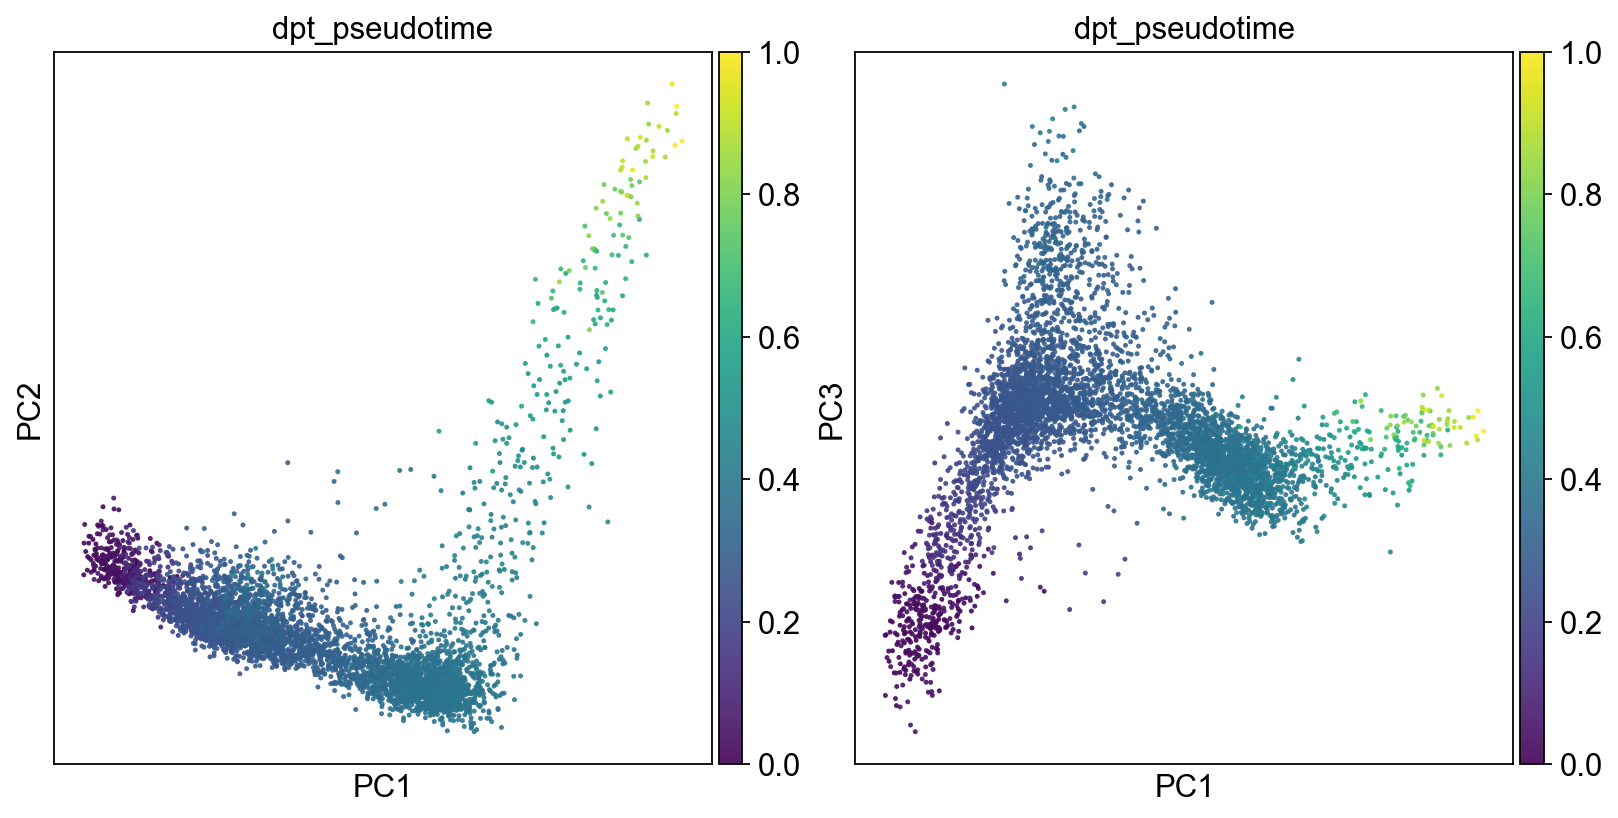

In [82]:
fig, axs = plt.subplots(1,2, figsize=(10,5), constrained_layout=True)
sc.pl.pca(adM1X, color=["dpt_pseudotime"], alpha=.9, s=20, components="1,2",legend_loc='on data', ax=axs[0], show=False)
sc.pl.pca(adM1X, color=["dpt_pseudotime"], alpha=.9, s=20, components="1,3",legend_loc='on data', ax=axs[1], show=False)

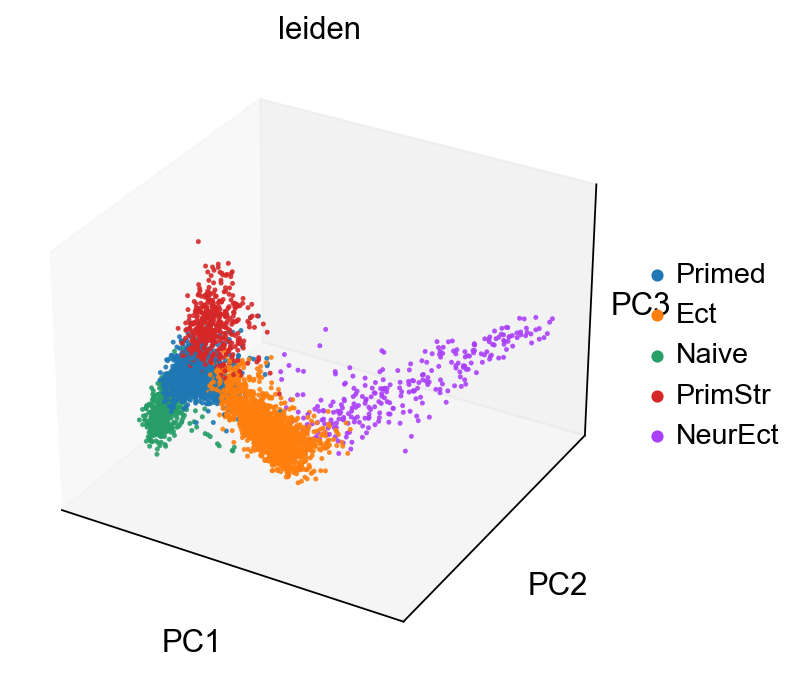

In [83]:
sc.pl.pca(adM1X, color=["leiden"], alpha=.9, s=25, projection='3d')

In [84]:
sc.tl.paga(adM1X, groups='leiden')

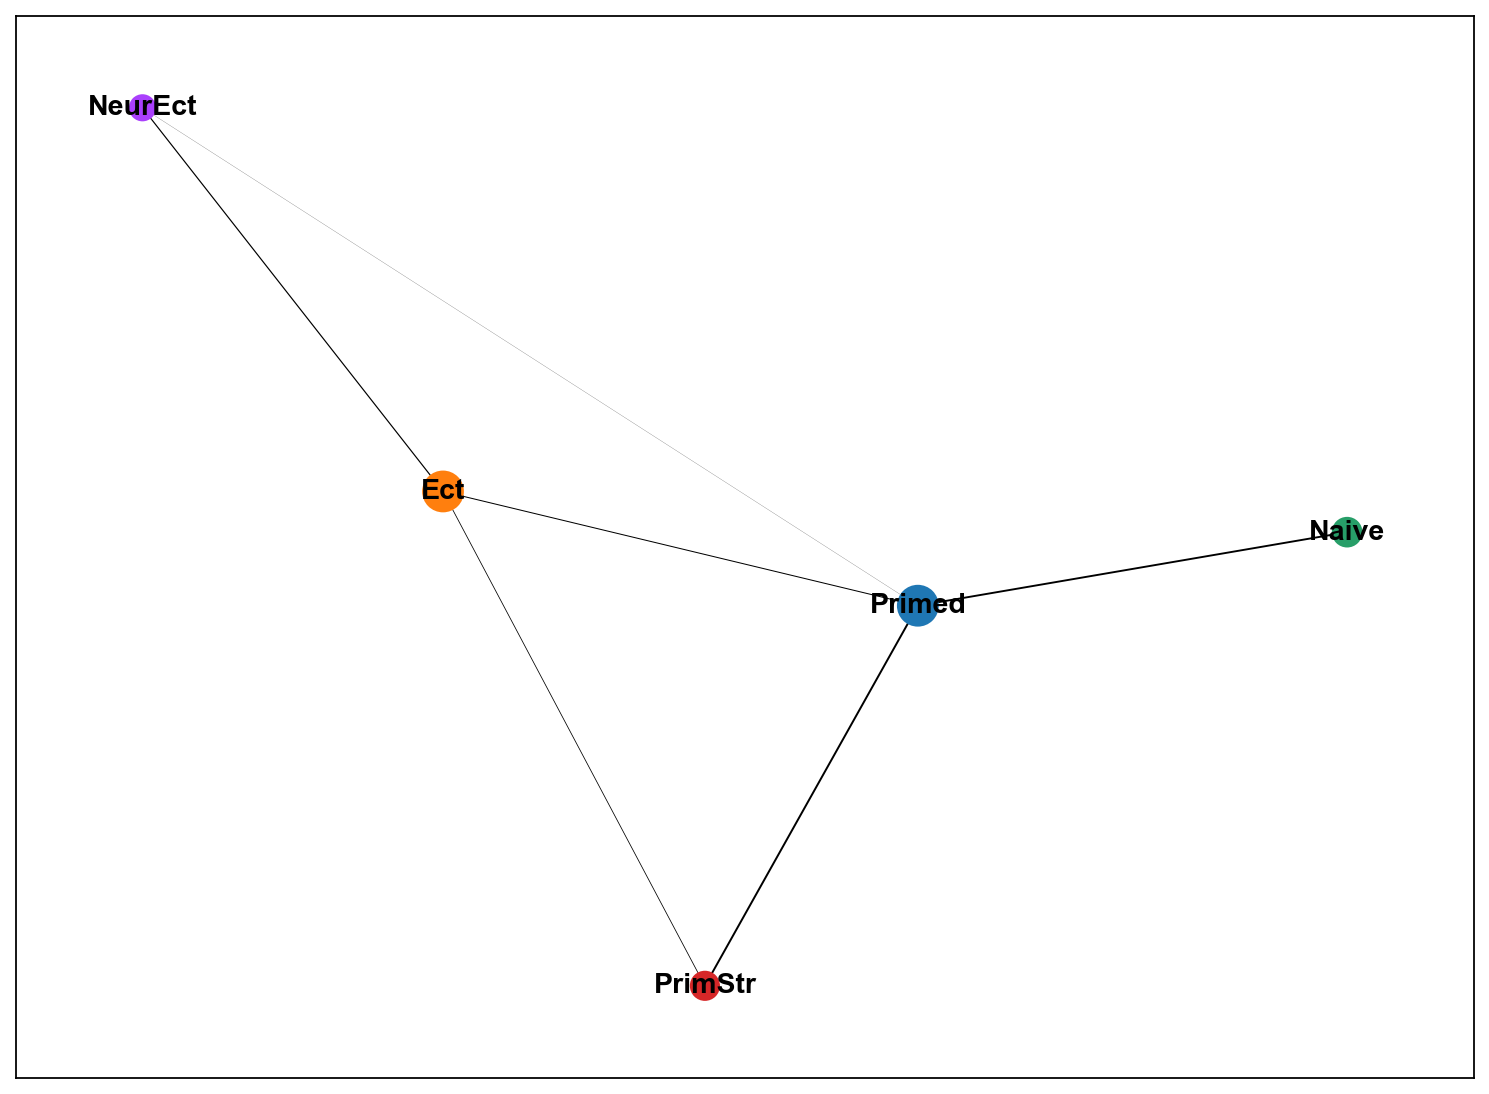

In [85]:

sc.set_figure_params(figsize="10, 8")
sc.pl.paga(adM1X, color=['leiden'])

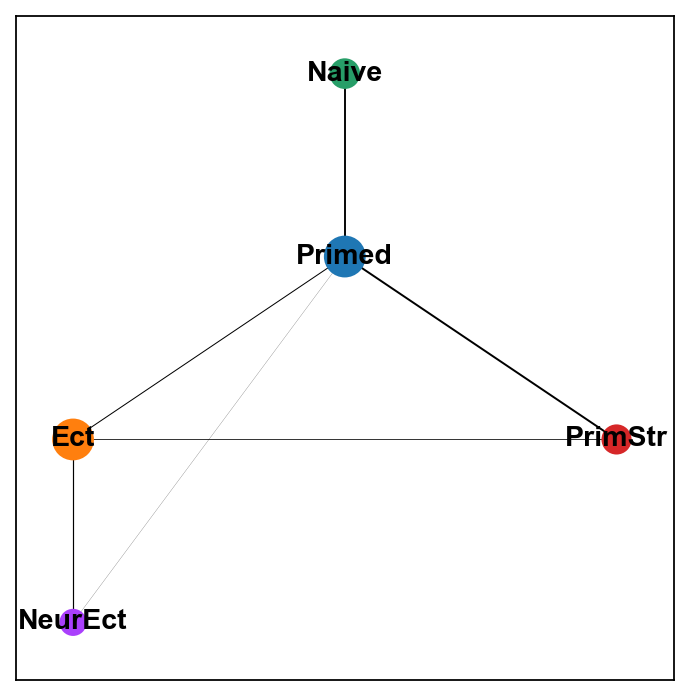

In [86]:
sc.set_figure_params(figsize="5, 5")
sc.pl.paga(adM1X,color=['leiden'], layout="rt", root=2, single_component=True)

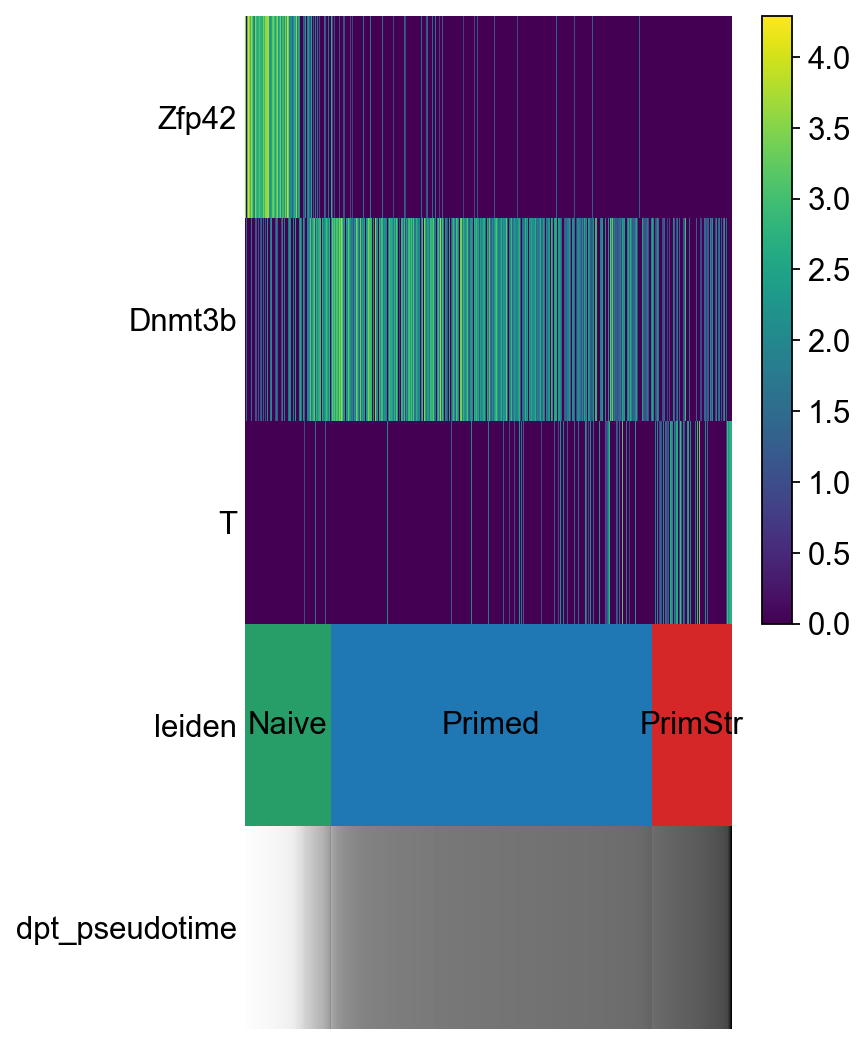

In [87]:
sc.pl.paga_path(adM1X, ["Naive", "Primed", "PrimStr"], keys=["Zfp42","Dnmt3b", "T"])

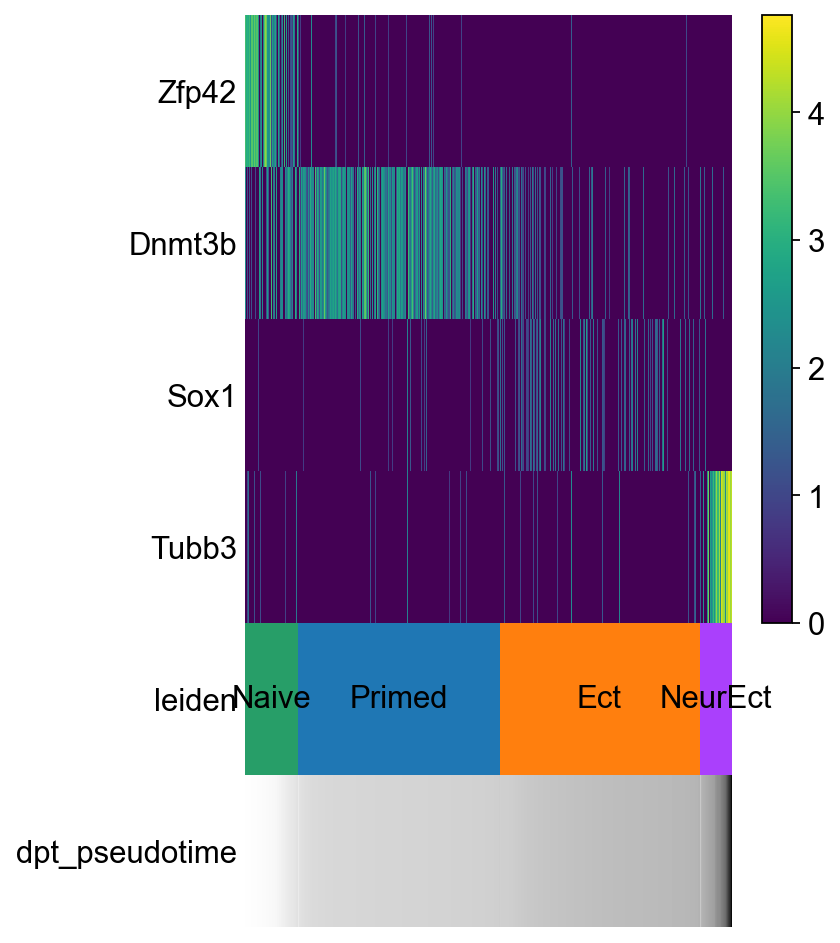

In [88]:
sc.pl.paga_path(adM1X, ["Naive", "Primed", "Ect", "NeurEct"], keys=["Zfp42","Dnmt3b", "Sox1", "Tubb3"])

How to find other genes dynamically expressed???


In [89]:
from scipy import stats
from pygam import GAM, s,l

In [90]:

def gamFit(expMat,genes,celltime):

    genes2=(set(genes) & set(expMat.index))
    def abcd(input_data):
        z=pd.DataFrame()
        z["z"]=input_data.values
        z["t"]=celltime.values
        z.index=expMat.columns
        X=celltime.values.reshape((celltime.shape[0],1))
        y=z["z"].values

        gam=GAM(l(0)).fit(X,y)
        p=gam.statistics_['p_values'][0]
        return p
    ans=expMat.loc[genes2][celltime.index].apply(abcd,axis=1)
    return ans

In [91]:

def findDynGenes(adata, group_column="leiden", pseudotime_column="dpt_pseudotime"):
    
    sampTab=pd.DataFrame(adata.obs)
    #sampTab.rename(columns={'psuedotime':'pseudotime'}, inplace=True)
    
    genes=adata.var.index
    expDat=pd.DataFrame(adata.X).T
    expDat.columns=sampTab.index
    expDat.index=genes
    expDat=expDat.loc[expDat.sum(axis=1)!=0]



    sampTab["dpt_groups"]=sampTab[group_column]
    sampTab["pseudotime"]=sampTab[pseudotime_column]
    sampTab["cell_name"]=sampTab.index
    path=np.unique(sampTab["dpt_groups"])
    ids=[]
    for grp in path:
        a=sampTab.loc[sampTab["dpt_groups"]==grp]
        b=a["cell_name"]
        ids=np.append(ids,b)
    sampTab=sampTab.loc[ids,:]
    #print(sampTab)
    expDat=expDat[ids]
    t1=sampTab["pseudotime"]
    t1C=t1[ids]
    print("starting gamma...")
    #print(expDat[t1C.index])
    gpChr=pd.DataFrame(gamFit(expDat[t1C.index],expDat.index,t1))
    gpChr.columns=["dynamic_pval"]
    

    cells=pd.DataFrame()
    cells["cell_name"]=pd.DataFrame(t1).index
    cells["pseudotime"]=t1.values
    cells["group"]=sampTab["dpt_groups"].values
    cells.index=cells["cell_name"]
    cells=cells.sort_values(by="pseudotime")
    #ans=list([gpChr,cells])
    adata.uns["genes"]=gpChr
    adata.uns["cells"]=cells
    print("Done. Dynamic pvalues stored in .uns['genes']. Ordered cells and pseudotime stored in .uns['cells'].")
    return adata

In [92]:
adM1X.var

gene_ids     mt   ribo  n_cells_by_counts  \
Xkr4            ENSMUSG00000051951  False  False                 37   
Sox17           ENSMUSG00000025902  False  False                214   
Mrpl15          ENSMUSG00000033845  False  False               3083   
Lypla1          ENSMUSG00000025903  False  False               1300   
Tcea1           ENSMUSG00000033813  False  False               2025   
...                            ...    ...    ...                ...   
Vamp7           ENSMUSG00000051412  False  False                810   
Spry3           ENSMUSG00000061654  False  False                  5   
PISD            ENSMUSG00000095041  False  False               2648   
DHRSX           ENSMUSG00000063897  False  False                363   
CAAA01147332.1  ENSMUSG00000095742  False  False                 13   

                mean_counts  pct_dropout_by_counts  total_counts  n_cells  \
Xkr4               0.007031              99.315449          38.0       36   
Sox17              0.121369              96.040703         656.0      200   
Mrpl15             1.093617              42.960222        5911.0     2830   
Lypla1             0.289732              75.948196        1566.0     1183   
Tcea1              0.507678              62.534690        2744.0     1861   
...                     ...                    ...           ...      ...   
Vamp7              0.168178              85.013876         909.0      732   
Spry3              0.000925              99.907493           5.0        5   
PISD               0.801295              51.008326        4331.0     2500   
DHRSX              0.071230              93.283996         385.0      332   
CAAA01147332.1     0.002405              99.759482          13.0       10   

                highly_variable     means  dispersions  dispersions_norm  \
Xkr4                      False  0.016082     0.963253         -0.801470   
Sox17                      True  0.244202     2.411042          5.504012   
Mrpl15                    False  1.180537     1.363256          0.195734   
Lypla1                    False  0.525076     1.226516         -0.061477   
Tcea1                     False  0.782626     1.229165         -0.092551   
...                         ...       ...          ...               ...   
Vamp7                      True  0.342350     1.298021          0.319167   
Spry3                     False  0.002563     1.157727         -0.120449   
PISD                       True  1.132169     1.546269          0.887386   
DHRSX                     False  0.147751     1.128050         -0.224374   
CAAA01147332.1            False  0.006232     1.560306          1.289330   

                    mean       std  
Xkr4            0.008202  0.099437  
Sox17           0.073287  0.385733  
Mrpl15          0.840333  0.822898  
Lypla1          0.302540  0.578844  
Tcea1           0.496253  0.697680  
...                  ...       ...  
Vamp7           0.181930  0.466421  
Spry3           0.001203  0.039912  
PISD            0.749295  0.840005  
DHRSX           0.077331  0.302422  
CAAA01147332.1  0.002586  0.061683  

[15567 rows x 14 columns]

In [93]:
ad2 = adM1X[:,adM1X.var["highly_variable"] ].copy()

In [94]:
ad2

AnnData object with n_obs × n_vars = 5060 × 2808
    obs: 'sampleName', 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices'
    var: 'gene_ids', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'leiden_colors', 'rank_genes_groups', 'diffmap_evals', 'iroot', 'dpt_changepoints', 'dpt_grouptips', 'paga', 'leiden_sizes'
    obsm: 'X_pca', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [95]:
ad2 = findDynGenes(ad2, group_column="leiden",pseudotime_column="dpt_pseudotime")

starting gamma...
Done. Dynamic pvalues stored in .uns['genes']. Ordered cells and pseudotime stored in .uns['cells'].


In [96]:
ad2

AnnData object with n_obs × n_vars = 5060 × 2808
    obs: 'sampleName', 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'pseudotime', 'cell_name'
    var: 'gene_ids', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'leiden_colors', 'rank_genes_groups', 'diffmap_evals', 'iroot', 'dpt_changepoints', 'dpt_grouptips', 'paga', 'leiden_sizes', 'genes', 'cells'
    obsm: 'X_pca', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [97]:
ad2.uns["genes"]


dynamic_pval
App      1.110223e-16
Hoxb9    9.244451e-01
Fermt1   1.341522e-06
Psma1    6.203960e-01
Ly6e     2.817916e-09
...               ...
T        6.968422e-01
Upf3b    1.285656e-03
Tmem108  9.715784e-12
Flrt1    6.068190e-11
Slc48a1  1.462900e-01

[2808 rows x 1 columns]

In [98]:
ad2.uns["genes"].sort_values(by="dynamic_pval")

dynamic_pval
App     1.110223e-16
Slc2a1  1.110223e-16
Npr2    1.110223e-16
Celf3   1.110223e-16
Serp2   1.110223e-16
...              ...
Ypel5   9.924643e-01
Styx    9.932226e-01
Gpc3    9.944588e-01
Smg7    9.964382e-01
Zfp235  9.996370e-01

[2808 rows x 1 columns]

<AxesSubplot:ylabel='Frequency'>

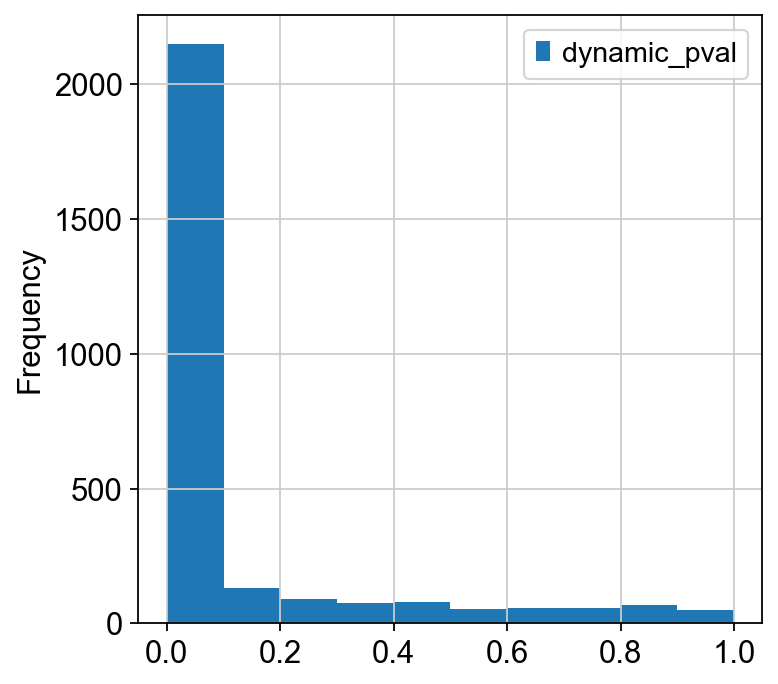

In [99]:
ad2.uns["genes"].plot.hist()

In [50]:
ad2.uns["cells"]

cell_name  pseudotime    group
cell_name                                              
AAAGACGATGATGC-1  AAAGACGATGATGC-1    0.000000    Naive
CCAGGTCTTTCCAT-1  CCAGGTCTTTCCAT-1    0.003910    Naive
GCTACAGAAGAAGT-1  GCTACAGAAGAAGT-1    0.003936    Naive
GAGGTTACCGACTA-1  GAGGTTACCGACTA-1    0.004223    Naive
GTTAAATGGTCTAG-1  GTTAAATGGTCTAG-1    0.004238    Naive
...                            ...         ...      ...
CAATCGGATGGTCA-1  CAATCGGATGGTCA-1    0.965796  NeurEct
AGGATGCTTCTGGA-1  AGGATGCTTCTGGA-1    0.975470  NeurEct
GATGCATGAACAGA-1  GATGCATGAACAGA-1    0.989113  NeurEct
GATTCTTGAAGGTA-1  GATTCTTGAAGGTA-1    0.999247  NeurEct
GGATGTACCTGTAG-1  GGATGTACCTGTAG-1    1.000000  NeurEct

[5060 rows x 3 columns]

In [100]:
dynGenes = ad2.uns["genes"]
dynGenes = dynGenes[dynGenes.values < 1e-15]
#dynGenes.index.values.tolist()

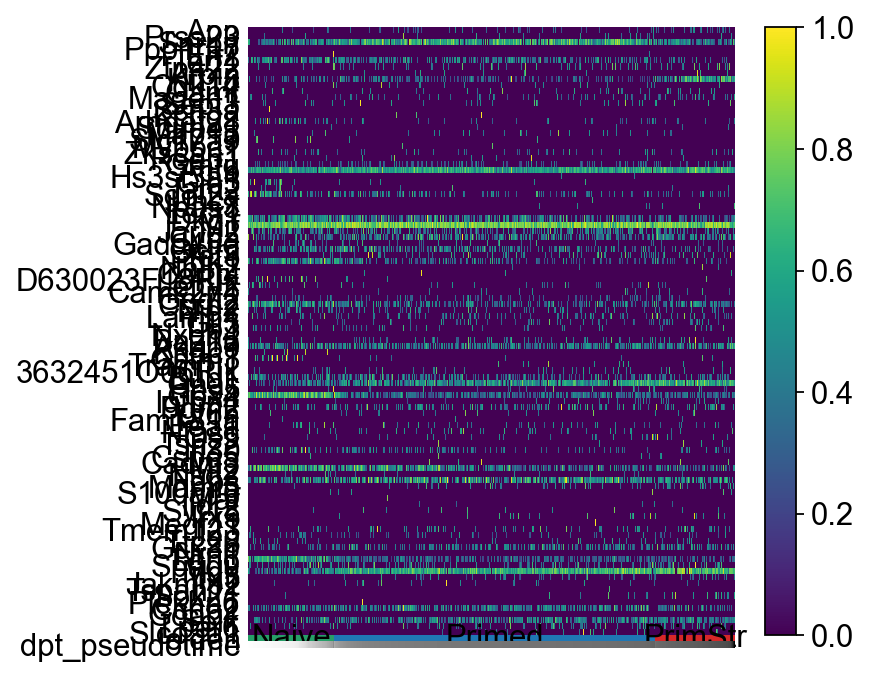

In [101]:
# dynGenes[0:4]
sc.pl.paga_path(ad2, ["Naive", "Primed", "PrimStr"], keys=dynGenes.index.values.tolist()[0:100], use_raw=False, normalize_to_zero_one=True)

In [102]:
ad2 = ad2[ ad2.uns["cells"].index ].copy()

In [54]:
ad2

AnnData object with n_obs × n_vars = 5060 × 2808
    obs: 'sampleName', 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'pseudotime', 'cell_name'
    var: 'gene_ids', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'leiden_colors', 'rank_genes_groups', 'diffmap_evals', 'iroot', 'dpt_changepoints', 'dpt_grouptips', 'paga', 'leiden_sizes', 'genes', 'cells'
    obsm: 'X_pca', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [103]:
expDat = ad2[:,dynGenes.index].X.T

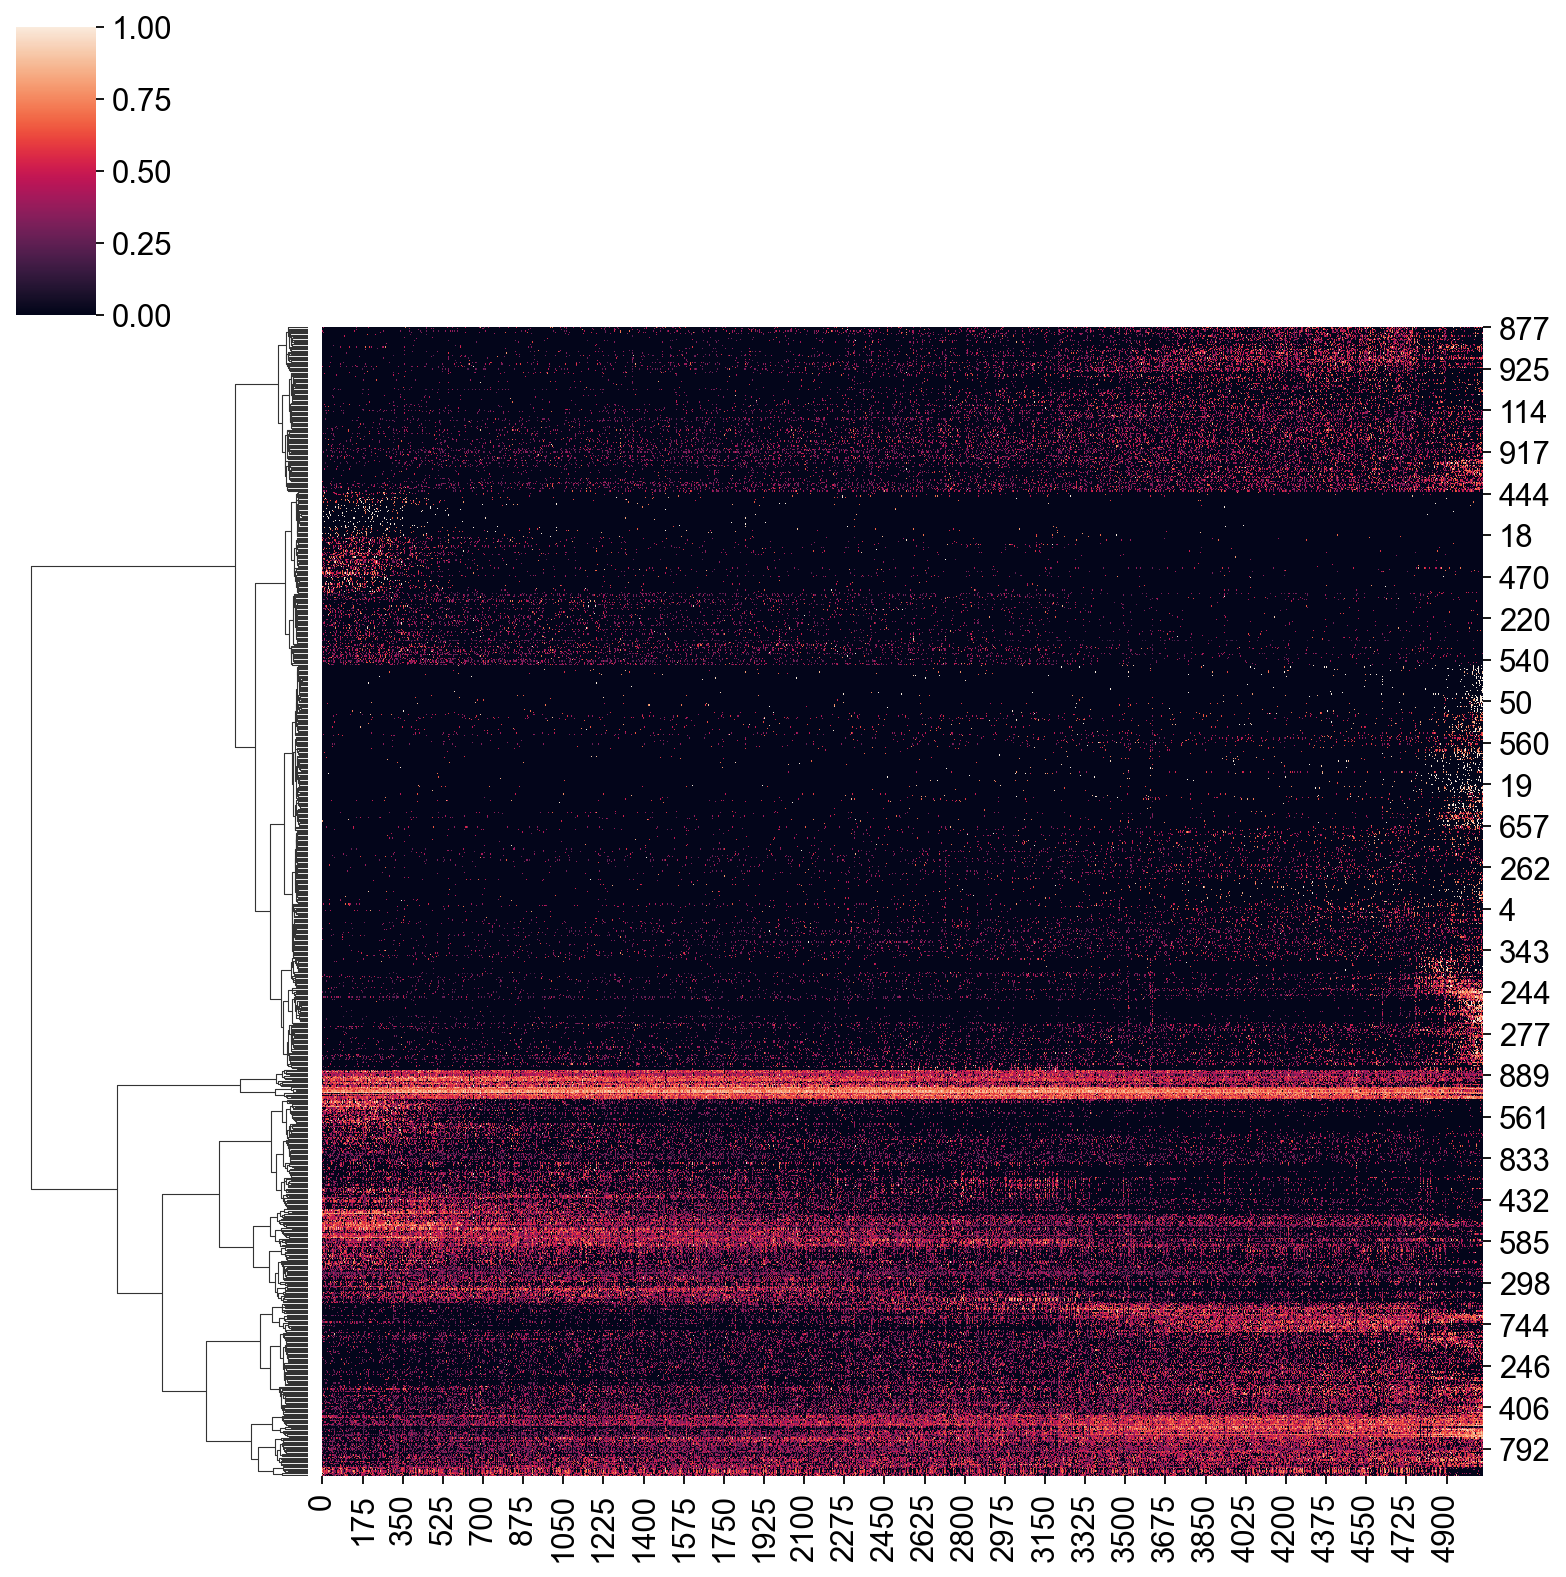

In [104]:
sns.clustermap(expDat, col_cluster=False, method="ward", standard_scale=0)

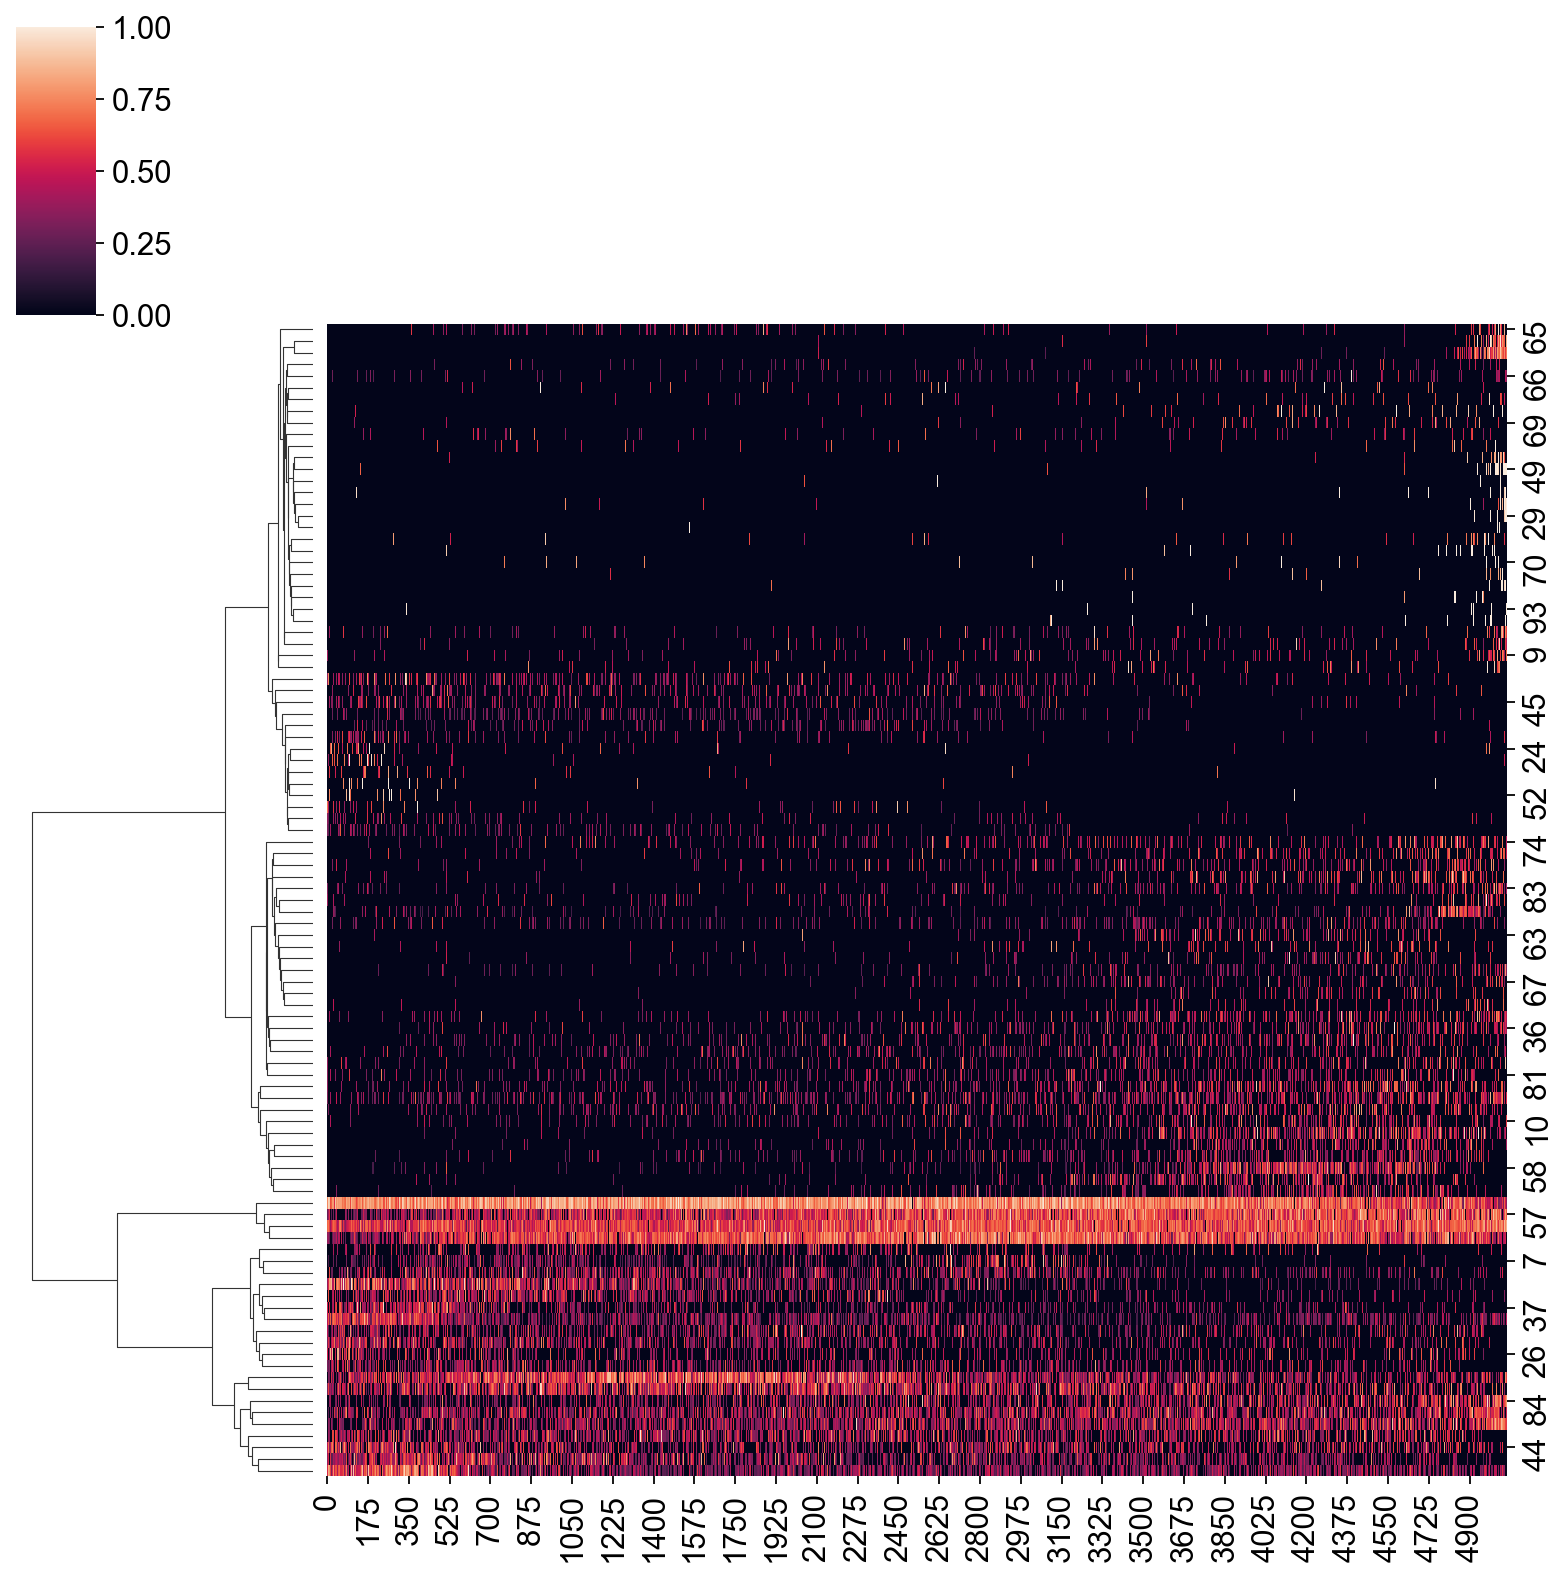

In [105]:
expDat = ad2[:,dynGenes[1:100].index].X.T
sns.clustermap(expDat, col_cluster=False, method="ward", standard_scale=0)

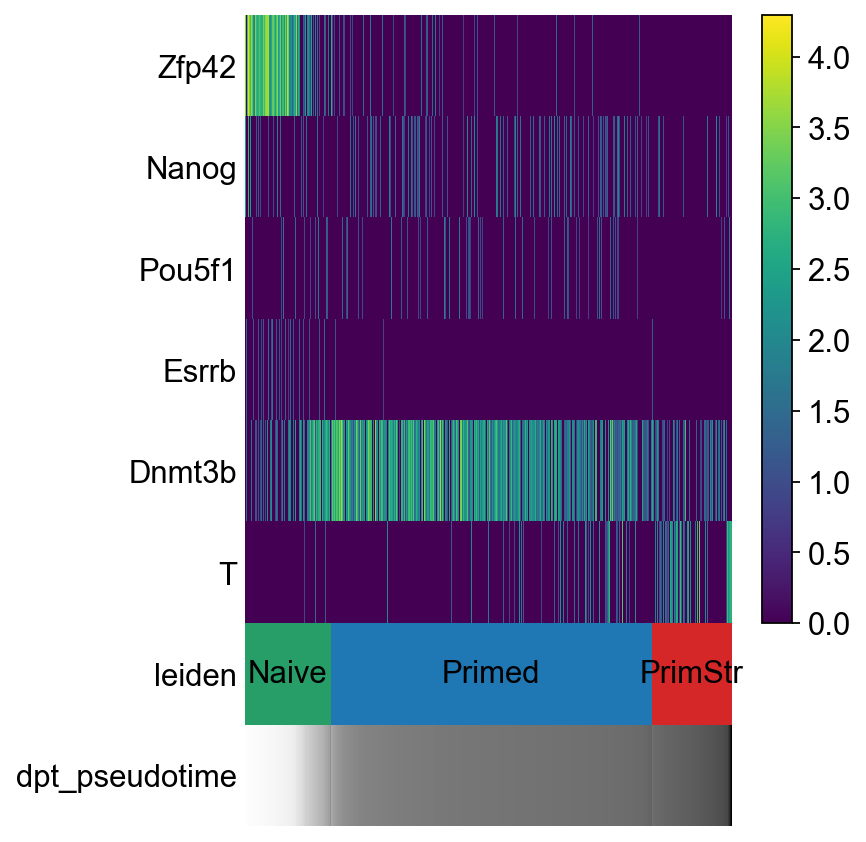

In [58]:
sc.pl.paga_path(adM1X, ["Naive", "Primed", "PrimStr"], keys=["Zfp42","Nanog", "Pou5f1", "Esrrb", "Dnmt3b", "T"])

In [106]:

import pySingleCellNet as pySCN

In [107]:
# load embryo classifier

from joblib import dump, load
tspRF_PRC = load("/Users/patrickcahan/Dropbox (Personal)/data/cscb/2022/TI/classifier/tspRF_Embryo_PRC_genes_113021.joblib") # warning
cgenesA_PRC = load("/Users/patrickcahan/Dropbox (Personal)/data/cscb/2022/TI/classifier/cgenesA_Embryo_PRC_genes_113021.joblib")
xpairs_PRC = load("/Users/patrickcahan/Dropbox (Personal)/data/cscb/2022/TI/classifier/xpairs_Embryo_PRC_genes_113021.joblib")

In [108]:
adata.obs['leiden'] = adM1Norm.obs['leiden'].copy()

In [109]:

adSCN = pySCN.scn_classify(adata, cgenesA_PRC, xpairs_PRC, tspRF_PRC, nrand = 0)

... storing 'SCN_class' as categorical


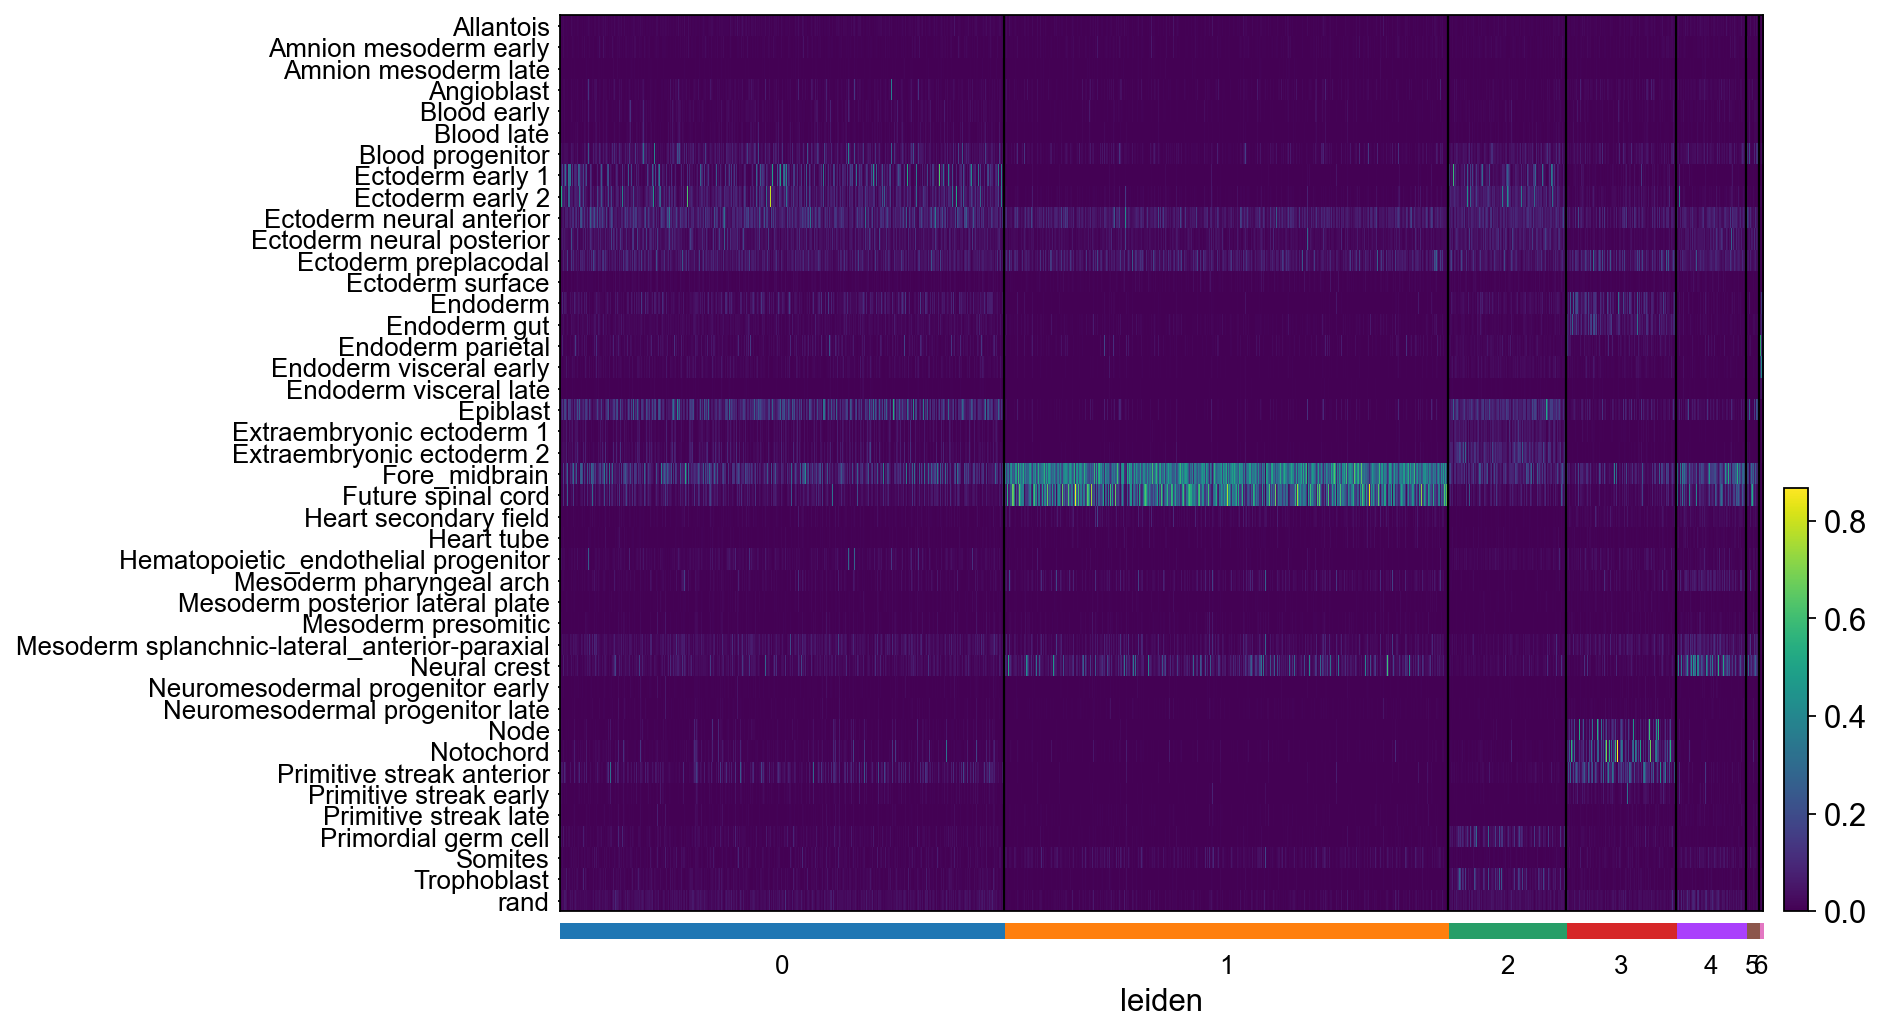

In [110]:
ax = sc.pl.heatmap(adSCN, adSCN.var_names.values, groupby='leiden', cmap='viridis', dendrogram=False, swap_axes=True)